# Importing Libraries

In [1]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm

from keras.applications.vgg16 import VGG16

# Defining the train,test and model directories

* We will create the directories for train,test and model training paths if not present

In [2]:
DATA_DIR = "../driver-dataset/imgs"
TEST_DIR = os.path.join(DATA_DIR,"test")
TRAIN_DIR = os.path.join(DATA_DIR,"train")

CSV_DIR = os.path.join(os.getcwd(),"csv_files")

MODEL_PATH = os.path.join(os.getcwd(),"model","vgg16")
PICKLE_PATH = os.path.join(os.getcwd(),"pickle")
TEST_CSV = os.path.join(os.getcwd(),"csv_files","test.csv")
TRAIN_CSV = os.path.join(os.getcwd(),"csv_files","train.csv")

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
else:
    shutil.rmtree(MODEL_PATH)
    os.makedirs(MODEL_PATH)
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_PATH)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)
    

In [4]:
os.listdir(os.getcwd())

['.DS_Store',
 'vgg-model.ipynb',
 'csv_files',
 'model',
 'pickle',
 '.ipynb_checkpoints']

In [5]:
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join(os.getcwd(),"csv_files",filename),index=False)

create_csv(TRAIN_DIR,"train.csv")
create_csv(TEST_DIR,"test.csv")
data_train = pd.read_csv(os.path.join(os.getcwd(),"csv_files","train.csv"))
data_test = pd.read_csv(os.path.join(os.getcwd(),"csv_files","test.csv"))


In [6]:
data_train = pd.read_csv(TRAIN_CSV)
data_test = pd.read_csv(TEST_CSV)

In [7]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

labels = to_categorical(data_train['ClassName'])
print(labels.shape)

with open(os.path.join(PICKLE_PATH,"labels_list_vgg16.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

{'c0': 0, 'c2': 1, 'c6': 2, 'c1': 3, 'c9': 4, 'c3': 5, 'c4': 6, 'c7': 7, 'c8': 8, 'c5': 9}
(22424, 10)


# Data Preparation

1. Converting the all the train and test images into image size of 64,64,3 
2. Standardizing the flattened image vector 

In [8]:
xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|██████████| 4485/4485 [00:19<00:00, 231.48it/s]


# MODEL ARCHITECTURE

## Approach Used
1. Removing the top layer of VGG16 model
2. Using the n-1 layers of VGG16 to predict the last layer of it using the flattened image vector 
3. The last layer thus achieved is a dense feature representation for a particular image
4. Passing this layer feature through a GlobalAveragePooling Layer and a further dense softmax layer for each of 10 classes

## Benefits

1. Making CNN architecture from scratch involves in training of all the deep layers which results in slow training
2. Instead of a large sparse image vector a dense feature representation used here requires less memory while training

In [10]:
model = VGG16(include_top=False)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
train_vgg16 = model.predict(train_tensors,verbose=1)
valid_vgg16 = model.predict(valid_tensors,verbose=1)

141/141 [==============================] - 30s 211ms/step


In [14]:
print("Train shape",train_vgg16.shape)
print("Validation shape",valid_vgg16.shape)

Train shape (17939, 2, 2, 512)
Validation shape (4485, 2, 2, 512)


In [12]:
train_features = train_vgg16[0]
valid_features = valid_vgg16[0]

In [13]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 512)
Validation features shape (2, 2, 512)


In [14]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
VGG16_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 5,130
Trainable params: 5,130
Non-trainable params: 0
_________________________________________________________________


In [15]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

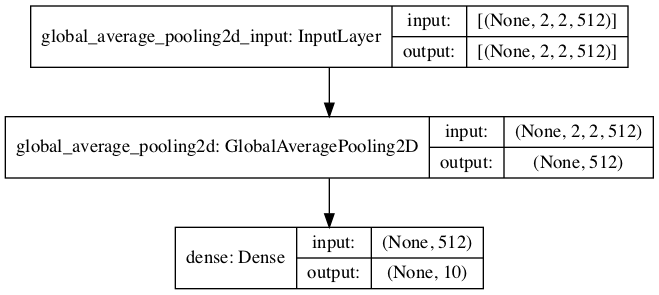

In [16]:
plot_model(VGG16_model,to_file=os.path.join(os.getcwd(),"model","vgg16","model_distracted_driver_vgg16.png"),show_shapes=True,show_layer_names=True)

In [17]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [21]:
model_history = VGG16_model.fit(train_vgg16,ytrain,validation_data = (valid_vgg16, ytest),epochs=20, batch_size=16, shuffle=True,callbacks=callbacks_list)

Epoch 1/20
1122/1122 [==============================] - 1s 757us/step - loss: 0.4298 - accuracy: 0.8844 - val_loss: 0.4846 - val_accuracy: 0.8651

Epoch 00001: val_accuracy improved from 0.86310 to 0.86511, saving model to /Users/manojkumar/Desktop/dmml2/vgg-16/model/vgg16/distracted-01-0.87.hdf5
Epoch 2/20
1122/1122 [==============================] - 1s 750us/step - loss: 0.4185 - accuracy: 0.8899 - val_loss: 0.4719 - val_accuracy: 0.8711

Epoch 00002: val_accuracy improved from 0.86511 to 0.87113, saving model to /Users/manojkumar/Desktop/dmml2/vgg-16/model/vgg16/distracted-02-0.87.hdf5
Epoch 3/20
1122/1122 [==============================] - 1s 716us/step - loss: 0.4082 - accuracy: 0.8919 - val_loss: 0.4590 - val_accuracy: 0.8731

Epoch 00003: val_accuracy improved from 0.87113 to 0.87313, saving model to /Users/manojkumar/Desktop/dmml2/vgg-16/model/vgg16/distracted-03-0.87.hdf5
Epoch 4/20
1122/1122 [==============================] - 1s 733us/step - loss: 0.3995 - accuracy: 0.8926 - 

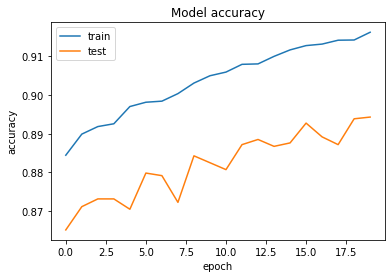

In [24]:
# Summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



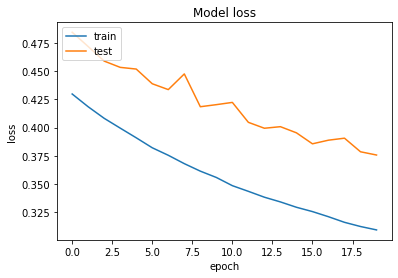

In [25]:
# Summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Analysis
Finding the Confusion matrix,Precision,Recall and F1 score to analyse the model thus created

In [26]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [27]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [28]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = VGG16_model.predict(valid_vgg16,verbose=1)

141/141 [==============================] - 0s 604us/step


## Confusion Matrix

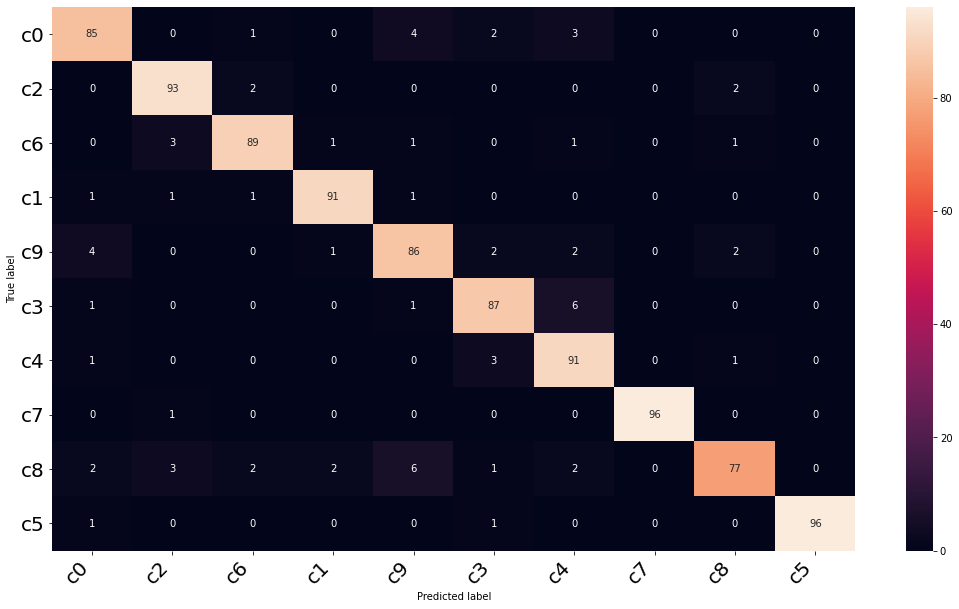

In [29]:
print_heatmap(ytest,ypred,class_names)

# Precision Recall F1 Score

In [30]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [31]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.894314
Precision: 0.895088
Recall: 0.894314
F1 score: 0.894083
